In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,p=0.5):
    seq=''
    for c in seed:
        if random.random() < p: c = random.choice(alphabet_list)
        seq += c
    return seq

def make_artificial_dataset(alphabet='ACGT', motives=None, motif_length=6, 
                            sequence_length=100, n_sequences=1000, n_motives=2, p=0.2,
                           random_state=1):
    random.seed(random_state)
    alphabet_list=[c for c in alphabet]
    
    if motives is None:
        motives=[]
        for i in range(n_motives):
            motives.append(random_string(motif_length,alphabet_list))
    else:
        motif_length = len(motives[0])
        n_motives = len(motives)
    
    sequence_length = sequence_length / len(motives)
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences

    counter=0
    seqs=[]
    for i in range(n_seq_per_motif):
        total_seq = ''
        total_binary_seq=''
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,p)
            seq = left_flanking + noisy_motif + right_flanking
            total_seq += seq
        seqs.append(('ID%d'%counter,total_seq))
        counter += 1
    binary_skeleton = '0' * flanking_length + '1' * motif_length + '0' * flanking_length
    binary_seq = binary_skeleton * n_motives
    return motives, seqs, binary_seq

In [37]:
from eden.motif import SequenceMotif
#help(SequenceMotif)

# Experimental Setup

In [53]:
#setup parameters
alphabet='ACGT'
semi_len=5
motives=['A'*semi_len+'C'*semi_len,
         #'C'*semi_len+'A'*semi_len,
         #'A'*semi_len+'T'*semi_len,
         'T'*semi_len+'A'*semi_len]
sequence_length=40
n_sequences=200
p=0.8
n_motives = 2
motif_length = 10

#make dataset
motives, seqs, binary_seqs = make_artificial_dataset(alphabet=alphabet,
                                        motives=motives,
                                        #n_motives = n_motives,
                                        #motif_length = motif_length,
                                        sequence_length=sequence_length,
                                        n_sequences=n_sequences,
                                        p=p,
                                        random_state=8)

In [3]:
from utilities import Weblogo
from IPython.display import Image, display

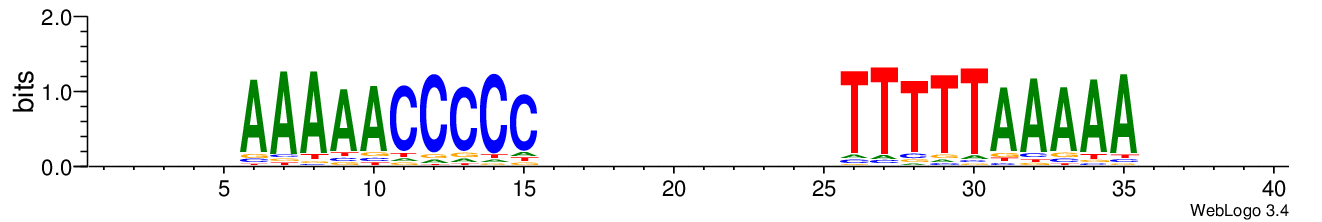

In [63]:
img = Weblogo().create_logo(seqs)
display(Image(img))

In [41]:
# display first 10 sequences and the corresponding binary sequences
for i in range(10):
    print seqs[i][0]
    print seqs[i][1]
    print binary_seqs[i][1]
    print

>ID0
ATAGAAATACCCCCCATAGCAGCGCATTTTAAAAAGCGTG
0000011111111110000000000111111111100000

>ID1
ATAGGAATAACCCCCTTGAACTTACTTTCTAAAAAAGTAT
0000011111111110000000000111111111100000

>ID2
AAAGCAAAAACTCCTTGGTATTGATATTCTAAAAACAGCC
0000011111111110000000000111111111100000

>ID3
ACAGGAAAAACCCCGGACCATGTTATTTTTAACAACGTCT
0000011111111110000000000111111111100000

>ID4
CCGTGAAAAAGCCTCTGTGCCTGCTTTTTTAAAAACCTTG
0000011111111110000000000111111111100000

>ID5
TTTAGAGAAATCCCCGACTTTGGCCTCTTTAAGAACCGAG
0000011111111110000000000111111111100000

>ID6
GTGCTACATTCCCCCGCGTTTTGTCTTTTTAAAAACTGCG
0000011111111110000000000111111111100000

>ID7
TGACAGAATACCTGCCTCGGTCTGCTTTATAAAAAAACCC
0000011111111110000000000111111111100000

>ID8
GCGTTAAAAACCCCCGGCTCCCCGGTTTTTAGAAAAATAT
0000011111111110000000000111111111100000

>ID9
GGGGATGAAACCCACTCTCTTGCGGTTTTTAAAAACGAAA
0000011111111110000000000111111111100000



In [42]:
#display
print 'Motives and sample of their perturbed variants:'
alphabet_list=[c for c in alphabet]
for motif in motives: 
    print
    print 'true motif:', motif, ' noisy: ',
    for i in range(4):
        print perturb(motif,alphabet_list,p=p),

Motives and sample of their perturbed variants:

true motif: AAAAACCCCC  noisy:  TCAAACCCCC ATATACCCCC AAAAACCCCC TAAAACCCCC
true motif: TTTTTAAAAA  noisy:  TTTATAAAAA TTTTTAAAAA TTTTTCAAAA TTTTTAAAAG


In [4]:
from sklearn.cluster import KMeans
from eden_wrapper import EdenWrapper
from meme_wrapper import Meme
from smod_wrapper import SMoDWrapper

In [44]:
# Parameters for tools

alphabet = 'dna'    # Sequence type
scoring_criteria = "pwm"    # ["pwm", "hmm"]
nmotifs = 4    # No. of motives to be found
minw = len(motives[0])-2    # Minimum width of motif
maxw = len(motives[0])+2    # Maximum width of motif

from utilities import Weblogo
wl = Weblogo(output_format='png',
             sequence_type='dna',
             resolution=200,
             stacks_per_line=40,
             units='probability')

<h3>For EDeN:</h3>

In [9]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)

In [10]:
%%time
km = KMeans(n_clusters=nmotifs)
tool = EdenWrapper(alphabet=alphabet,
                   scoring_criteria = scoring_criteria,
                   complexity=5, 
                   nbits=14, 
                   negative_ratio=3,
                   min_subarray_size=minw, 
                   max_subarray_size=maxw,
                   clustering_algorithm=km,
                   
                   weblogo_obj=wl)
tool.fit(seqs)

Positive data: Instances: 200 ; Features: 16385 with an avg of 5662 features per instance
Negative data: Instances: 600 ; Features: 16385 with an avg of 5877 features per instance
Elapsed time: 44.9 secs
model induction: 200 positive instances 46 s
motives extraction: 246 motives in 13s
motives clustering: 4 clusters in 1s
after filtering: 238 motives 4 clusters in 0s
motif model construction in 0s
updated motif counts in 0s
CPU times: user 29.7 s, sys: 2.73 s, total: 32.4 s
Wall time: 1min 3s


<h3>For MEME:</h3>

In [94]:
%%time
# save input sequences as fasta file for MEME tool
with open('seqs.fa','w') as f_train:
    for seq in seqs:
        f_train.write('>' + seq[0] + ' \n')
        f_train.write(seq[1] + '\n')

tool =  Meme(alphabet='dna',
             scoring_criteria = scoring_criteria,
             minw=minw,
             maxw=maxw,
             nmotifs=nmotifs,
             
             weblogo_obj=wl)
tool.fit('seqs.fa')

CPU times: user 104 ms, sys: 40 ms, total: 144 ms
Wall time: 8.64 s


<h3> For SMoD:</h3>

In [54]:
tool = SMoDWrapper(scoring_criteria = 'pwm',
                   #complexity = complexity,
                   #n_clusters = n_clusters,
                   min_subarray_size = 8,
                   max_subarray_size = 12,
                   pos_block_size = 20,
                   neg_block_size = 20,
                   clusterer = KMeans(),
                   min_score = 7,
                   min_freq = 0.69,
                   min_cluster_size = 1,
                   similarity_th = 0.5,
                   freq_th = 0.69,
                   p_value=1,
                   regex_th=0.92,
                   #sample_size=sample_size,
                   std_th=0.48
                   )
from eden.modifier.seq import seq_to_seq, shuffle_modifier
neg_seqs = seq_to_seq(seqs, modifier=shuffle_modifier, times=1, order=2)
neg_seqs = list(neg_seqs)

block_size=n_sequences/8

pos_size = len(seqs)
train_pos_seqs = seqs[:pos_size/2]
test_pos_seqs = seqs[pos_size/2:]

neg_size = len(neg_seqs)
train_neg_seqs = neg_seqs[:neg_size/2]
test_neg_seqs = neg_seqs[neg_size/2:]
tool.fit(seqs, neg_seqs)
#smod.display_logo()

In [55]:
tool.display()

        0      1      2      3      4      5      6      7      8      9     10
-:   0.50   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
A:   0.00   0.50   0.00   0.00   0.00   1.00   0.00   0.00   0.00   0.00   1.00
C:   0.50   0.00   0.00   1.00   1.00   0.00   0.00   1.00   1.00   0.50   0.00
G:   0.00   0.50   1.00   0.00   0.00   0.00   1.00   0.00   0.00   0.00   0.00
T:   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.50   0.00

        0      1      2      3      4      5      6      7      8      9     10     11
-:   0.00   0.50   0.50   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.50   0.50
A:   1.00   0.00   0.00   0.00   0.00   0.00   0.00   1.00   0.00   0.00   0.00   0.50
C:   0.00   0.00   0.50   0.00   1.00   0.00   0.00   0.00   0.00   1.00   0.50   0.00
G:   0.00   0.50   0.00   1.00   0.00   0.00   0.00   0.00   1.00   0.00   0.00   0.00
T:   0.00   0.00   0.00   0.00   0.00   1.00   1.00   0.00   0.00   0.00   0.00   0.

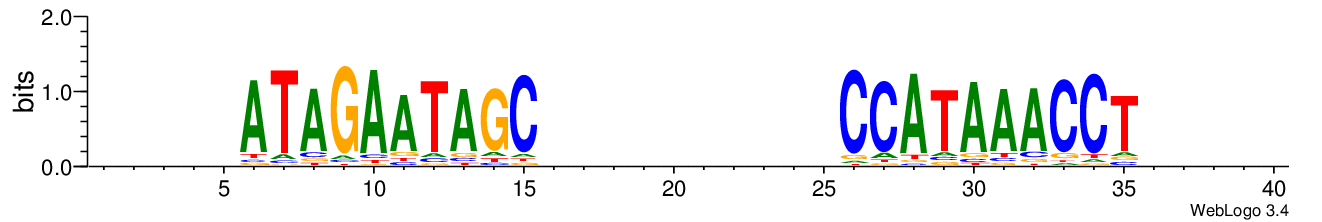

Average over all sequences


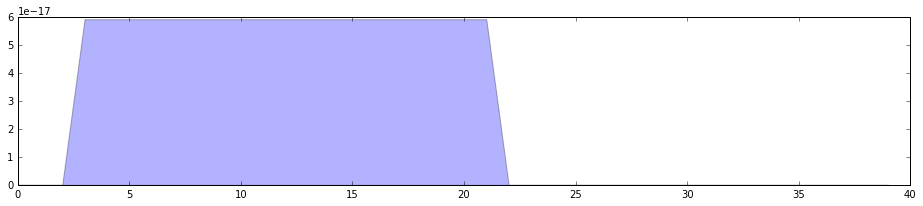

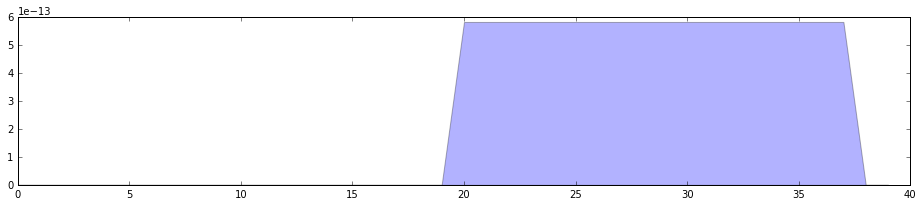


for individual sequences


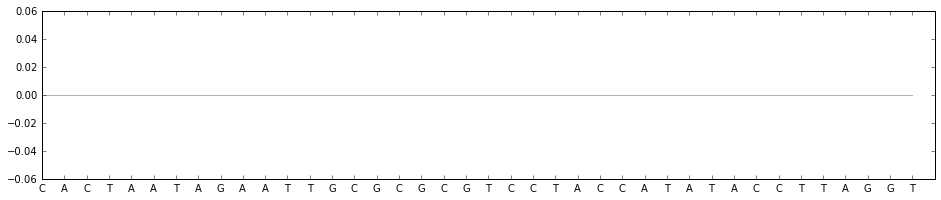

In [99]:
% matplotlib inline

img = Weblogo().create_logo(seqs)
display(Image(img))

import pylab as plt 
import numpy as np
sig = np.zeros(sequence_length)

print "Average over all sequences"
for j in range(len(motives)):
    for i in range(len(seqs)):
        score = tool.score(motif_num=j+1, seq=seqs[i][1])
        sig += np.array(score)
    sig /= float(len(seqs))
    #sig *= len(motives)
    plt.figure(figsize=(16,3))
    plt.fill_between(range(len(sig)), 0, sig, alpha=0.3)
    plt.show()


print
print "for individual sequences"

for i in range(len(seqs[:10])):
    sig = np.zeros(sequence_length)
    for j in range(len(motives)):
        score = tool.score(motif_num=j+1, seq=seqs[i][1])
        sig += np.array(score)
    sig /= float(len(seqs))
    sig *= len(motives)
    plt.figure(figsize=(16,3))
    plt.fill_between(range(len(sig)), 0, sig, alpha=0.3)
    plt.xticks(range(len(sig)), seqs[i][1])
    plt.show()

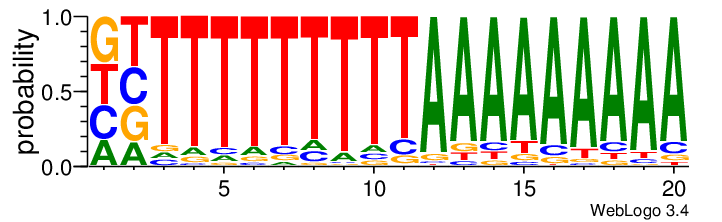

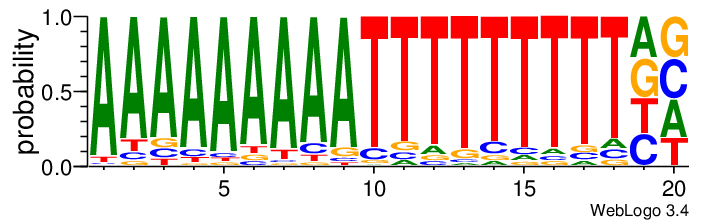

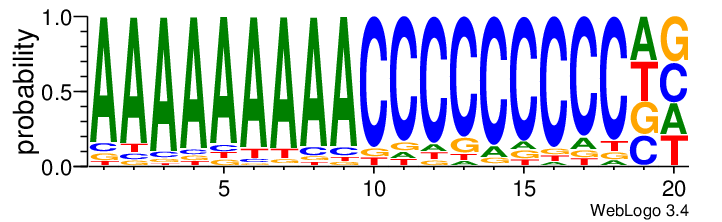

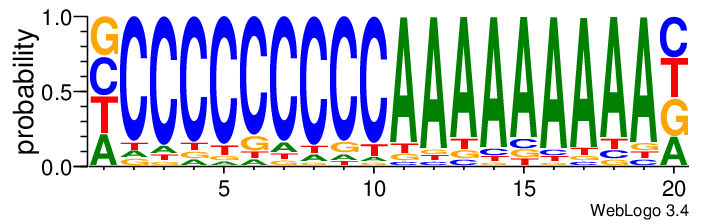

In [21]:
tool.display_logo(do_alignment=True)

<h1>Scoring Methods Comparison</h1>

<h2>Scoring with PWM</h2>

In [22]:
%%time
test_seq = seqs[0][1]
score_pwm = tool.score(motif_num=1, seq=test_seq)
print score_pwm

[2.081911965929634e-14, 5.2757524291839265e-17, 1.0210469211002624e-17, 2.8777142743138093e-15, 5.2145794967159266e-18, 5.615698030490886e-21, 3.602512882618652e-22, 9.640745945565149e-23, 1.1174093019854318e-23, 4.0787457165811803e-25, 3.722871480469391e-25, 9.495673161158559e-23, 1.836976780861523e-26, 9.290153920647594e-24, 7.548250060526172e-22, 1.0204049926802083e-20, 8.921518025125857e-21, 1.652408455811946e-19, 4.8491074442448796e-21, 1.4209244098238678e-19, 1.3803607857838013e-21, 1.2341076640677424e-18, 5.7305133242869754e-21, 2.420942407245905e-21, 5.0675363615126264e-24, 6.332576766121355e-22, 3.745683831062127e-21, 9.316412825096773e-21, 1.300714081347494e-19, 8.614118519408e-23, 1.1401423637962047e-22, 3.28220762044957e-22, 1.4047201268072436e-21, 5.06678237604e-25, 2.104525862151618e-20, 1.172649303006197e-22, 1.4688560114468176e-22, 3.576057282891844e-24, 3.387054982968658e-23, 2.842993058897474e-22, 1.5673810991565905e-21, 1.8607014460570877e-21, 1.804852813800267e-20, 

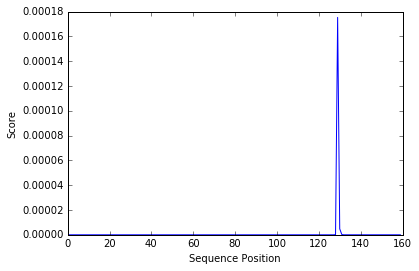

In [23]:
import matplotlib.pyplot as plt
plt.plot(score_pwm)
plt.xlabel('Sequence Position')
plt.ylabel('Score')
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score

true_score = [float(int(x)) for x in binary_seqs[0][1]]
roc_score = roc_auc_score(true_score, score_pwm)
print "ROC Score: ", roc_score


ROC Score:  0.489820075758


<h2>Scoring with HMM</h2>

In [32]:
%%time
km = KMeans(n_clusters=nmotifs)
tool = EdenWrapper(alphabet=alphabet,
                   scoring_criteria = "hmm",
                   complexity=5, 
                   nbits=14, 
                   negative_ratio=3,
                   min_subarray_size=5, 
                   max_subarray_size=7,
                   clustering_algorithm=km,
                   
                   weblogo_obj=wl)
tool.fit(seqs)

Positive data: Instances: 200 ; Features: 16385 with an avg of 5662 features per instance
Negative data: Instances: 600 ; Features: 16385 with an avg of 5877 features per instance
Elapsed time: 57.6 secs
model induction: 200 positive instances 59 s
motives extraction: 90 motives in 15s
motives clustering: 4 clusters in 0s
after filtering: 17 motives 4 clusters in 0s
motif model construction in 0s
updated motif counts in 0s
CPU times: user 39.5 s, sys: 5.07 s, total: 44.6 s
Wall time: 1min 18s


In [33]:
%%time
test_seq = seqs[0][1]
score_mm = tool.score(motif_num=1, seq=test_seq)
print score_mm

[-230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -25.619725748245855, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.25850929940458, -230.2585092

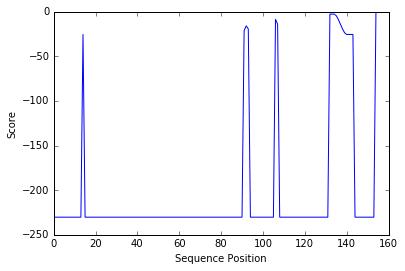

In [34]:
import matplotlib.pyplot as plt
plt.plot(score_mm)
plt.xlabel('Sequence Position')
plt.ylabel('Score')
plt.show()

In [35]:
true_score = [float(int(x)) for x in binary_seqs[0][1]]
roc_score = roc_auc_score(true_score, score_mm)
print "ROC Score: ", roc_score

ROC Score:  0.582386363636
